## Setting

In [119]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import torch
import torch.nn as nn
import numpy as np
import sys

import os
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import imp
import importlib
sys.path.append("/content/drive/My Drive/LCNN/")


Mounted at /content/drive


In [123]:
sys.path.append("./../")

import LCNN
imp.reload(LCNN)
from LCNN import adjust,accuracy,one_hot,adjust_
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print(torch.cuda.device_count())
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla P100-PCIE-16GB
1
Memory Usage:
Allocated: 0.0 GB
Cached:    0.1 GB


In [34]:
from torch.utils.data.sampler import SubsetRandomSampler

In [35]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)) ])

batchsize=64
dataset_dir = '/home/liu0003/Desktop/datasets'

trainset = datasets.MNIST(dataset_dir, download=True, train=True, transform=transform)
valset = datasets.MNIST(dataset_dir, download=True, train=False, transform=transform)



train_loader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=False, sampler=SubsetRandomSampler(range(batchsize)), worker_init_fn=np.random.seed(0))
test_loader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False, worker_init_fn=np.random.seed(0))

# 2 layers network

In [36]:
class NeuralNet2layer(nn.Module):
    def __init__(self, input_size, hidden_size1,num_classes, initialize='NTK',batchnorm=False):
        super(NeuralNet2layer, self).__init__()
        self.initialize=initialize
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.batchnorm = batchnorm

        self.fc1 = nn.Linear(input_size, hidden_size1) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias=False)


        if self.batchnorm:
            self.bn1 = nn.BatchNorm1d(num_features=hidden_size1)
        
        if self.initialize=='NTK':

            self.fc1.weight.detach().uniform_(-1, 1)
            self.fc1.bias.detach().uniform_(-1, 1)
            self.fc2.weight.detach().uniform_(-1,1)

            
    def forward(self, x):
        if self.batchnorm:
            if self.initialize=='LeCun':
                out = self.fc1(x)
                out = self.bn1(out)
                out = self.relu1(out)
                out = self.fc2(out)

            if self.initialize=='NTK':
                out = self.fc1(x)
                out = out/np.sqrt(self.input_size)
                out = self.bn1(out)
                out = self.relu1(out)
                out = self.fc2(out)
                out = out/np.sqrt(self.hidden_size1)
        else:

            if self.initialize=='LeCun':
                out = self.fc1(x)
                out = self.relu1(out)
                out = self.fc2(out)

            if self.initialize=='NTK':
                out = self.fc1(x)
                out = out/np.sqrt(self.input_size)
                out = self.relu1(out)
                out = self.fc2(out)
                out = out/np.sqrt(self.hidden_size1)
        return out
    
    
     

def loss_and_accuracy(model,loader, criterion, acc_bool = False):
# def loss_and_accuracy(model,loader, criterion):
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    t=0
    c=0
    total_loss = 0
    
    model.eval()

    with torch.no_grad():    
        if not acc_bool:
            for i, (images, labels) in enumerate(loader):
                images = images.view(images.shape[0], -1).to(device)
                outputs = model(images)
                loss = criterion(outputs, one_hot(labels, 10)).to(device)
                total_loss += loss

                c=c+len(outputs)
            return total_loss/c
        
        else: 
            for i, (images, labels) in enumerate(loader):
                images = images.view(images.shape[0], -1).to(device)
                outputs = model(images)
                loss = criterion(outputs, one_hot(labels, 10)).to(device)
                total_loss += loss
                
                t=t+(torch.argmax(outputs,dim=1) == labels).float().sum()
                c=c+len(outputs)
            return t/c*100 , total_loss/c


def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
    
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 12 
mpl.rcParams['ytick.labelsize'] = 12 
    
def plot_loss_acc(step_list, loss_dict, acc_dict, title, fig_save_path):
    
    fig, axs = plt.subplots(1, 2, figsize=(9, 3))


    axs[0].plot(step_list, loss_dict['train'], label = 'train', linewidth = 3 ,  linestyle =  '--')
    axs[0].plot(step_list,loss_dict['test'], label = 'test', linewidth = 3)
    axs[0].legend(frameon = False, fontsize = 12)
    axs[0].set_xlabel('Iter num', fontsize = 15)
    axs[0].set_ylabel('Loss', fontsize = 15)


    axs[1].plot(step_list, acc_dict['train'], label = 'train', linewidth = 3, linestyle =  '--')
    axs[1].plot(step_list, acc_dict['test'], label = 'test', linewidth = 3)
    axs[1].legend(frameon = False, fontsize = 12)
    axs[1].set_xlabel('Iter num', fontsize = 15)
    axs[1].set_ylabel('Acc', fontsize = 15)


#     title = '784-800-10; no scaling; no bn; full batch; train data size = 64'
    plt.suptitle(title, fontsize = 17)

    axs[0] = simpleaxis(axs[0])
    axs[1] = simpleaxis(axs[1])
    plt.subplots_adjust(bottom=0.2)
    plt.savefig(fig_save_path + title, format='png')
    
    return fig


def plot_loss(step_list, loss_dict, title, fig_save_path):
    
    fig, axs = plt.subplots(1, figsize=(4, 3))


    axs.plot(step_list, loss_dict['train'], label = 'train', linewidth = 3 ,  linestyle =  '--')
    axs.plot(step_list,loss_dict['test'], label = 'test', linewidth = 3)
    axs.legend(frameon = False, fontsize = 12)
    axs.set_xlabel('Iter num', fontsize = 15)
    axs.set_ylabel('Loss', fontsize = 15)

    plt.suptitle(title, fontsize = 17)

    axs = simpleaxis(axs)
    plt.subplots_adjust(bottom=0.2)
#     plt.savefig(fig_save_path + title, format='png')
    
    return fig

In [133]:
total_run_steps = 100

store_every = 1

shared_model_param_dict = {'input_size': 784, 'hidden_size1': 800, 'num_classes': 10, 
                           'total_run_steps': total_run_steps, 'criterion': nn.MSELoss(), 
                         'train_loader': train_loader, 'test_loader': test_loader, 
                          'store_every': store_every, 'weight_decay': 0}

fig_save_path = './Figures/fullbatch/'

In [175]:
def full_batch_train(initialize, batchnorm, learning_rate, weight_decay, input_size, hidden_size1, num_classes, criterion, total_run_steps, train_loader, test_loader, store_every  ):
    images, labels = next(iter(train_loader))
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels, 10).to(device)

    torch.manual_seed(0)
    model = NeuralNet2layer(input_size = input_size, hidden_size1 = hidden_size1, num_classes = num_classes, initialize=initialize,batchnorm = batchnorm).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9, weight_decay = weight_decay)


    train_losslist=[]
#     train_aclist=[]

    test_losslist=[]
#     test_aclist=[]
    
    iter_list = []
    
    for runsteps in range(total_run_steps):
        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if runsteps%store_every==0 :  
            iter_list.append(runsteps)
            train_loss = loss_and_accuracy(model, train_loader , criterion)
            test_loss = loss_and_accuracy(model, test_loader , criterion)

            train_losslist.append(train_loss)

            test_losslist.append(test_loss)

#             print ('Iter: %03d/%03d | Train Loss: %.8f | Train acc: %.4f' %(runsteps, total_run_steps, train_loss, train_ac))   
            print ('Iter: %03d/%03d | Train Loss: %.8f' %(runsteps, total_run_steps, train_loss))   

    loss_dict = {'train': train_losslist, 'test': test_losslist}
    
    train_ac, train_loss = loss_and_accuracy(model, train_loader , criterion, acc_bool = True)
    test_ac, test_loss = loss_and_accuracy(model, test_loader , criterion, acc_bool = True)
    
#     acl_dict = {'train': train_aclist, 'test': test_aclist}
    print()
    print('Iter: %03d/%03d | Test Loss: %.8f | Test acc: %.4f' %(runsteps, total_run_steps, test_loss, test_ac) )
#     return iter_list, loss_dict, acl_dict
    return iter_list, loss_dict, train_loss

In [190]:
def full_batch_train_(scale,therd,mode,testlossflage,initialize, batchnorm, learning_rate, weight_decay, input_size, hidden_size1, num_classes, criterion, total_run_steps, train_loader, test_loader, store_every):
    images, labels = next(iter(train_loader))
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels, 10).to(device)

    torch.manual_seed(0)
    model = NeuralNet2layer(input_size = input_size, hidden_size1 = hidden_size1, num_classes = num_classes, initialize=initialize,batchnorm = batchnorm).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9, weight_decay = weight_decay)


    train_losslist=[]
#     train_aclist=[]

    test_losslist=[]
#     test_aclist=[]
    
    iter_list = []
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    lold=1000
    train_loss=100
    for runsteps in range(total_run_steps):
        #if (lold<train_loss and runsteps<20) or (runsteps==0):
        if (lold<train_loss) or (runsteps==0):
            model.fc1.register_forward_hook(get_activation('fc1'))
            outputs=model(images).to(device)
            adjust_(model,activation['fc1'],images,threshold_u=1.0/therd,threshold_l=therd,scale=scale,ln=1,oflag=1,mode=mode,shuff=0)
        
        lold=train_loss
        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if runsteps%store_every==0: 
            iter_list.append(runsteps)
            train_loss = loss_and_accuracy(model, train_loader , criterion)
            if testlossflage:
                test_loss = loss_and_accuracy(model, test_loader , criterion)
                test_losslist.append(test_loss)

            train_losslist.append(train_loss)

            

#             print ('Iter: %03d/%03d | Train Loss: %.8f | Train acc: %.4f' %(runsteps, total_run_steps, train_loss, train_ac))   
            print ('Iter: %03d/%03d | Train Loss: %.8f' %(runsteps, total_run_steps, train_loss))   

    loss_dict = {'train': train_losslist, 'test': test_losslist}
    
    train_ac, train_loss = loss_and_accuracy(model, train_loader , criterion, acc_bool = True)
    test_ac, test_loss = loss_and_accuracy(model, test_loader , criterion, acc_bool = True)
    
#     acl_dict = {'train': train_aclist, 'test': test_aclist}
    print()
    print('Iter: %03d/%03d | Test Loss: %.8f | Test acc: %.4f' %(runsteps, total_run_steps, test_loss, test_ac) )
#     return iter_list, loss_dict, acl_dict
    return iter_list, loss_dict,train_loss

In [117]:
step_list, loss_no_scale_no_bn,train_loss = full_batch_train_(1,0.8,0,initialize = 'LeCun', batchnorm = False, learning_rate = 0.1, ** shared_model_param_dict)
print(train_loss)

Adjusting Layer 1, Kernel Nodes: 662, Adptive Nodes:138
Iter: 000/050 | Train Loss: 0.00400724
Iter: 001/050 | Train Loss: 0.00260391
Iter: 002/050 | Train Loss: 0.00136370
Iter: 003/050 | Train Loss: 0.00095701
Iter: 004/050 | Train Loss: 0.00098666
Adjusting Layer 1, Kernel Nodes: 688, Adptive Nodes:112
Iter: 005/050 | Train Loss: 0.00076271
Iter: 006/050 | Train Loss: 0.00059651
Iter: 007/050 | Train Loss: 0.00057251
Iter: 008/050 | Train Loss: 0.00058819
Adjusting Layer 1, Kernel Nodes: 719, Adptive Nodes:81
Iter: 009/050 | Train Loss: 0.00053403
Iter: 010/050 | Train Loss: 0.00042141
Iter: 011/050 | Train Loss: 0.00035162
Iter: 012/050 | Train Loss: 0.00035212
Adjusting Layer 1, Kernel Nodes: 722, Adptive Nodes:78
Iter: 013/050 | Train Loss: 0.00034337
Iter: 014/050 | Train Loss: 0.00027041
Iter: 015/050 | Train Loss: 0.00021140
Iter: 016/050 | Train Loss: 0.00021192
Adjusting Layer 1, Kernel Nodes: 798, Adptive Nodes:2
Iter: 017/050 | Train Loss: 0.00019342
Iter: 018/050 | Train 

In [124]:
# 1.2 0.53. runstep=2
maxstep=1000
for scale in range(10):
    scale=(scale-2)*0.02+0.9
    for therd in range(10):
        therd=(therd-2)*0.02+0.8
        print('scale:{:03f},therd:{:03f}'.format(scale,therd))
        step_list, loss_no_scale_no_bn,train_loss = full_batch_train_(scale,therd,2,initialize = 'LeCun', batchnorm = False, learning_rate = 0.1, ** shared_model_param_dict)
        if maxstep>train_loss:
            maxstep=train_loss
            sb=scale
            th=therd
print(maxstep,sb,th)

Streaming output truncated to the last 5000 lines.
Iter: 004/050 | Train Loss: 0.00099082
Iter: 005/050 | Train Loss: 0.00079656
Iter: 006/050 | Train Loss: 0.00067748
Iter: 007/050 | Train Loss: 0.00063430
Iter: 008/050 | Train Loss: 0.00061610
Iter: 009/050 | Train Loss: 0.00058713
Iter: 010/050 | Train Loss: 0.00052183
Iter: 011/050 | Train Loss: 0.00043607
Iter: 012/050 | Train Loss: 0.00037665
Iter: 013/050 | Train Loss: 0.00036192
Iter: 014/050 | Train Loss: 0.00035000
Iter: 015/050 | Train Loss: 0.00030744
Iter: 016/050 | Train Loss: 0.00026291
Iter: 017/050 | Train Loss: 0.00023913
Iter: 018/050 | Train Loss: 0.00022535
Iter: 019/050 | Train Loss: 0.00020611
Iter: 020/050 | Train Loss: 0.00017521
Iter: 021/050 | Train Loss: 0.00014427
Iter: 022/050 | Train Loss: 0.00013430
Iter: 023/050 | Train Loss: 0.00013495
Adjusting Layer 1, Kernel Nodes: 688, Adptive Nodes:112
Iter: 024/050 | Train Loss: 0.00011723
Iter: 025/050 | Train Loss: 0.00009445
Iter: 026/050 | Train Loss: 0.00008

In [ ]:
tensor(3.5891e-06) 0.92 0.8200000000000001. det2.
tensor(3.5231e-06) 0.9400000000000001 0.8400000000000001 det1
tensor(3.7707e-06) 0.86 0.8600000000000001 det0
tensor(3.4226e-06) 0.88 0.8400000000000001. d det1



In [134]:
step_list_, loss_no_scale_no_bn_,train_loss = full_batch_train_(0.88,0.84,2,initialize = 'LeCun', batchnorm = False, learning_rate = 0.1, ** shared_model_param_dict)

Adjusting Layer 1, Kernel Nodes: 668, Adptive Nodes:132
Iter: 000/100 | Train Loss: 0.00371951
Iter: 001/100 | Train Loss: 0.00206158
Iter: 002/100 | Train Loss: 0.00146285
Iter: 003/100 | Train Loss: 0.00089450
Iter: 004/100 | Train Loss: 0.00098715
Adjusting Layer 1, Kernel Nodes: 664, Adptive Nodes:136
Iter: 005/100 | Train Loss: 0.00074759
Iter: 006/100 | Train Loss: 0.00056731
Iter: 007/100 | Train Loss: 0.00056348
Iter: 008/100 | Train Loss: 0.00059008
Adjusting Layer 1, Kernel Nodes: 765, Adptive Nodes:35
Iter: 009/100 | Train Loss: 0.00052425
Iter: 010/100 | Train Loss: 0.00041020
Iter: 011/100 | Train Loss: 0.00035297
Iter: 012/100 | Train Loss: 0.00036342
Adjusting Layer 1, Kernel Nodes: 676, Adptive Nodes:124
Iter: 013/100 | Train Loss: 0.00035318
Iter: 014/100 | Train Loss: 0.00027621
Iter: 015/100 | Train Loss: 0.00021974
Iter: 016/100 | Train Loss: 0.00022089
Adjusting Layer 1, Kernel Nodes: 450, Adptive Nodes:350
Iter: 017/100 | Train Loss: 0.00021216
Iter: 018/100 | Tra

# No scaling, no batch norm

In [135]:
step_list, loss_no_scale_no_bn,train_loss = full_batch_train(initialize = 'LeCun', batchnorm = False, learning_rate = 0.1, ** shared_model_param_dict)

Iter: 000/100 | Train Loss: 0.00340580
Iter: 001/100 | Train Loss: 0.00159687
Iter: 002/100 | Train Loss: 0.00157065
Iter: 003/100 | Train Loss: 0.00082164
Iter: 004/100 | Train Loss: 0.00092534
Iter: 005/100 | Train Loss: 0.00077363
Iter: 006/100 | Train Loss: 0.00056668
Iter: 007/100 | Train Loss: 0.00053111
Iter: 008/100 | Train Loss: 0.00055974
Iter: 009/100 | Train Loss: 0.00052726
Iter: 010/100 | Train Loss: 0.00043010
Iter: 011/100 | Train Loss: 0.00035524
Iter: 012/100 | Train Loss: 0.00034616
Iter: 013/100 | Train Loss: 0.00035400
Iter: 014/100 | Train Loss: 0.00030334
Iter: 015/100 | Train Loss: 0.00023320
Iter: 016/100 | Train Loss: 0.00021664
Iter: 017/100 | Train Loss: 0.00022575
Iter: 018/100 | Train Loss: 0.00020093
Iter: 019/100 | Train Loss: 0.00015484
Iter: 020/100 | Train Loss: 0.00013146
Iter: 021/100 | Train Loss: 0.00012997
Iter: 022/100 | Train Loss: 0.00012480
Iter: 023/100 | Train Loss: 0.00010707
Iter: 024/100 | Train Loss: 0.00008404
Iter: 025/100 | Train Los

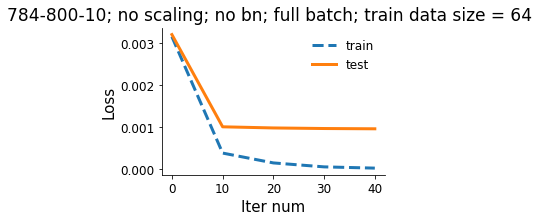

In [ ]:
title = '784-800-10; no scaling; no bn; full batch; train data size = 64'
# fig = plot_loss_acc(step_list, loss_no_scale_no_bn, aclist_no_scale_no_bn, title, fig_save_path)
fig = plot_loss(step_list, loss_no_scale_no_bn, title, fig_save_path)

del title

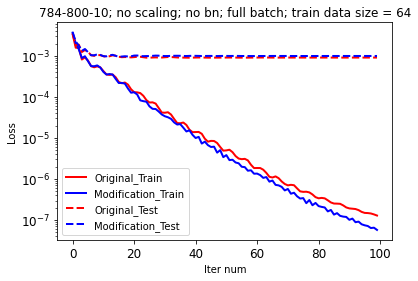

In [137]:
plt.plot(step_list,loss_no_scale_no_bn['train'],'r-',label='Original_Train',linewidth = 2)
plt.plot(step_list_,loss_no_scale_no_bn_['train'],'b-',label='Modification_Train',linewidth = 2)
plt.plot(step_list,loss_no_scale_no_bn['test'],'r--',label='Original_Test',linewidth = 2)
plt.plot(step_list_,loss_no_scale_no_bn_['test'],'b--',label='Modification_Test',linewidth = 2)
plt.title('784-800-10; no scaling; no bn; full batch; train data size = 64')
plt.xlabel('Iter num')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.savefig('/content/drive/My Drive/LCNN/newplots/attack1.pdf')

# No scaling + batch norm

In [191]:
# 1.2 0.53. runstep=2
maxstep=1000
for scale in range(10):
    scale=(scale-2)*0.05+0.9
    for therd in range(10):
        therd=(therd-2)*0.05+0.7
        print('scale:{:03f},therd:{:03f}'.format(scale,therd))
        step_list_, loss_no_scale_no_bn_,train_loss = full_batch_train_(scale,therd,2,False,initialize = 'LeCun', batchnorm = True, learning_rate = 0.1, ** shared_model_param_dict)
        if maxstep>train_loss:
            maxstep=train_loss
            sb=scale
            th=therd
print(maxstep,sb,th)

Streaming output truncated to the last 5000 lines.
Iter: 076/100 | Train Loss: 0.00000391
Iter: 077/100 | Train Loss: 0.00000368
Iter: 078/100 | Train Loss: 0.00000346
Iter: 079/100 | Train Loss: 0.00000324
Iter: 080/100 | Train Loss: 0.00000304
Iter: 081/100 | Train Loss: 0.00000289
Iter: 082/100 | Train Loss: 0.00000270
Iter: 083/100 | Train Loss: 0.00000255
Iter: 084/100 | Train Loss: 0.00000244
Iter: 085/100 | Train Loss: 0.00000230
Iter: 086/100 | Train Loss: 0.00000217
Iter: 087/100 | Train Loss: 0.00000206
Iter: 088/100 | Train Loss: 0.00000195
Iter: 089/100 | Train Loss: 0.00000186
Iter: 090/100 | Train Loss: 0.00000177
Iter: 091/100 | Train Loss: 0.00000169
Iter: 092/100 | Train Loss: 0.00000161
Iter: 093/100 | Train Loss: 0.00000153
Iter: 094/100 | Train Loss: 0.00000147
Iter: 095/100 | Train Loss: 0.00000140
Iter: 096/100 | Train Loss: 0.00000134
Iter: 097/100 | Train Loss: 0.00000128
Iter: 098/100 | Train Loss: 0.00000123
Iter: 099/100 | Train Loss: 0.00000117

Iter: 099/10

In [ ]:
tensor(6.6297e-08) 1.15 0.7999999999999999

In [192]:
step_list_, loss_no_scale_no_bn_,train_loss = full_batch_train_(1.25,0.75,2,True,initialize = 'LeCun', batchnorm = True, learning_rate = 0.1, ** shared_model_param_dict)

Adjusting Layer 1, Kernel Nodes: 641, Adptive Nodes:159
Iter: 000/100 | Train Loss: 0.00138989
Iter: 001/100 | Train Loss: 0.00149824
Adjusting Layer 1, Kernel Nodes: 596, Adptive Nodes:204
Iter: 002/100 | Train Loss: 0.00170627
Adjusting Layer 1, Kernel Nodes: 598, Adptive Nodes:202
Iter: 003/100 | Train Loss: 0.00358338
Adjusting Layer 1, Kernel Nodes: 341, Adptive Nodes:459
Iter: 004/100 | Train Loss: 0.00385473
Adjusting Layer 1, Kernel Nodes: 493, Adptive Nodes:307
Iter: 005/100 | Train Loss: 0.00193184
Iter: 006/100 | Train Loss: 0.00086206
Iter: 007/100 | Train Loss: 0.00053817
Iter: 008/100 | Train Loss: 0.00074729
Adjusting Layer 1, Kernel Nodes: 696, Adptive Nodes:104
Iter: 009/100 | Train Loss: 0.00056763
Iter: 010/100 | Train Loss: 0.00037454
Iter: 011/100 | Train Loss: 0.00040203
Adjusting Layer 1, Kernel Nodes: 363, Adptive Nodes:437
Iter: 012/100 | Train Loss: 0.00042029
Adjusting Layer 1, Kernel Nodes: 669, Adptive Nodes:131
Iter: 013/100 | Train Loss: 0.00027949
Iter: 

In [178]:
step_list, loss_no_scale_bn,train_loss = full_batch_train(initialize = 'LeCun', batchnorm = True, learning_rate = 0.1, ** shared_model_param_dict)

Iter: 000/100 | Train Loss: 0.00134803
Iter: 001/100 | Train Loss: 0.00147709
Iter: 002/100 | Train Loss: 0.00111018
Iter: 003/100 | Train Loss: 0.00078829
Iter: 004/100 | Train Loss: 0.00088465
Iter: 005/100 | Train Loss: 0.00056639
Iter: 006/100 | Train Loss: 0.00061762
Iter: 007/100 | Train Loss: 0.00041767
Iter: 008/100 | Train Loss: 0.00046920
Iter: 009/100 | Train Loss: 0.00033135
Iter: 010/100 | Train Loss: 0.00033680
Iter: 011/100 | Train Loss: 0.00030543
Iter: 012/100 | Train Loss: 0.00022692
Iter: 013/100 | Train Loss: 0.00025334
Iter: 014/100 | Train Loss: 0.00019167
Iter: 015/100 | Train Loss: 0.00015860
Iter: 016/100 | Train Loss: 0.00016925
Iter: 017/100 | Train Loss: 0.00013062
Iter: 018/100 | Train Loss: 0.00010653
Iter: 019/100 | Train Loss: 0.00011745
Iter: 020/100 | Train Loss: 0.00009153
Iter: 021/100 | Train Loss: 0.00006846
Iter: 022/100 | Train Loss: 0.00007593
Iter: 023/100 | Train Loss: 0.00006663
Iter: 024/100 | Train Loss: 0.00004766
Iter: 025/100 | Train Los

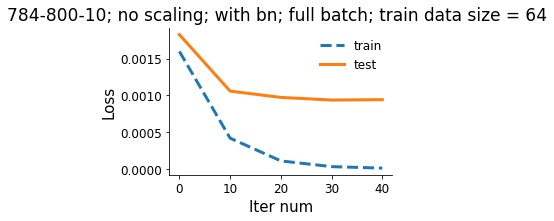

In [ ]:
title = '784-800-10; no scaling; with bn; full batch; train data size = 64'
fig = plot_loss(step_list, loss_no_scale_bn, title, fig_save_path)
del title

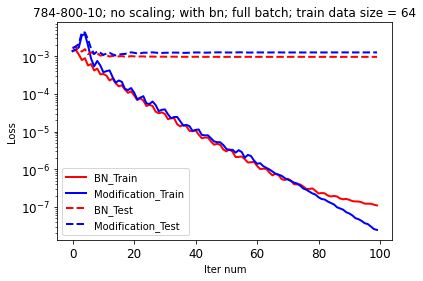

In [193]:
plt.plot(step_list,loss_no_scale_bn['train'],'r-',label='BN_Train',linewidth = 2)
plt.plot(step_list_,loss_no_scale_no_bn_['train'],'b-',label='Modification_Train',linewidth = 2)
plt.plot(step_list,loss_no_scale_bn['test'],'r--',label='BN_Test',linewidth = 2)
plt.plot(step_list_,loss_no_scale_no_bn_['test'],'b--',label='Modification_Test',linewidth = 2)
plt.title('784-800-10; no scaling; with bn; full batch; train data size = 64')
plt.xlabel('Iter num')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.savefig('/content/drive/My Drive/LCNN/newplots/attack2.pdf')

# NTK scaling, no batch norm

In [169]:
step_list,  loss_ntk_scale_no_bn, train_loss = full_batch_train(initialize = 'NTK', batchnorm = False, learning_rate = 0.1 * np.sqrt(784), ** shared_model_param_dict)

Iter: 000/100 | Train Loss: 0.00237281
Iter: 001/100 | Train Loss: 0.00200517
Iter: 002/100 | Train Loss: 0.00167512
Iter: 003/100 | Train Loss: 0.00149027
Iter: 004/100 | Train Loss: 0.00147401
Iter: 005/100 | Train Loss: 0.00157495
Iter: 006/100 | Train Loss: 0.00170266
Iter: 007/100 | Train Loss: 0.00177413
Iter: 008/100 | Train Loss: 0.00174776
Iter: 009/100 | Train Loss: 0.00163276
Iter: 010/100 | Train Loss: 0.00147414
Iter: 011/100 | Train Loss: 0.00132576
Iter: 012/100 | Train Loss: 0.00122586
Iter: 013/100 | Train Loss: 0.00118550
Iter: 014/100 | Train Loss: 0.00119055
Iter: 015/100 | Train Loss: 0.00121295
Iter: 016/100 | Train Loss: 0.00122473
Iter: 017/100 | Train Loss: 0.00120870
Iter: 018/100 | Train Loss: 0.00116260
Iter: 019/100 | Train Loss: 0.00109682
Iter: 020/100 | Train Loss: 0.00102778
Iter: 021/100 | Train Loss: 0.00097037
Iter: 022/100 | Train Loss: 0.00093247
Iter: 023/100 | Train Loss: 0.00091368
Iter: 024/100 | Train Loss: 0.00090696
Iter: 025/100 | Train Los

In [163]:
print(train_loss)

tensor(0.0003)


In [194]:
# 1.2 0.53. runstep=2
maxstep=1000
for scale in range(10):
    scale=(scale-2)*0.05+0.9
    for therd in range(10):
        therd=(therd-2)*0.05+0.7
        print('scale:{:03f},therd:{:03f}'.format(scale,therd))
        step_list_, loss_no_scale_no_bn_,train_loss = full_batch_train_(scale,therd,2,False,initialize = 'NTK', batchnorm = False, learning_rate = 0.1 * np.sqrt(784), ** shared_model_param_dict)
        if maxstep>train_loss:
            maxstep=train_loss
            sb=scale
            th=therd
print(maxstep,sb,th)

Streaming output truncated to the last 5000 lines.
Iter: 066/100 | Train Loss: 0.00018588
Iter: 067/100 | Train Loss: 0.00018201
Iter: 068/100 | Train Loss: 0.00017814
Iter: 069/100 | Train Loss: 0.00017443
Iter: 070/100 | Train Loss: 0.00017096
Iter: 071/100 | Train Loss: 0.00016765
Iter: 072/100 | Train Loss: 0.00016435
Iter: 073/100 | Train Loss: 0.00016106
Iter: 074/100 | Train Loss: 0.00015785
Iter: 075/100 | Train Loss: 0.00015481
Iter: 076/100 | Train Loss: 0.00015190
Iter: 077/100 | Train Loss: 0.00014904
Iter: 078/100 | Train Loss: 0.00014620
Iter: 079/100 | Train Loss: 0.00014341
Iter: 080/100 | Train Loss: 0.00014073
Iter: 081/100 | Train Loss: 0.00013816
Iter: 082/100 | Train Loss: 0.00013565
Iter: 083/100 | Train Loss: 0.00013317
Iter: 084/100 | Train Loss: 0.00013073
Iter: 085/100 | Train Loss: 0.00012836
Iter: 086/100 | Train Loss: 0.00012609
Iter: 087/100 | Train Loss: 0.00012387
Iter: 088/100 | Train Loss: 0.00012169
Iter: 089/100 | Train Loss: 0.00011955
Iter: 090/100

In [195]:
step_list_, loss_no_scale_no_bn_,train_loss = full_batch_train_(0.9,0.7,2,True,initialize = 'NTK', batchnorm = False, learning_rate = 0.1 * np.sqrt(784), ** shared_model_param_dict)

Adjusting Layer 1, Kernel Nodes: 725, Adptive Nodes:75
Iter: 000/100 | Train Loss: 0.00230411
Iter: 001/100 | Train Loss: 0.00187329
Iter: 002/100 | Train Loss: 0.00155647
Iter: 003/100 | Train Loss: 0.00147197
Iter: 004/100 | Train Loss: 0.00158650
Adjusting Layer 1, Kernel Nodes: 676, Adptive Nodes:124
Iter: 005/100 | Train Loss: 0.00177904
Adjusting Layer 1, Kernel Nodes: 615, Adptive Nodes:185
Iter: 006/100 | Train Loss: 0.00178685
Adjusting Layer 1, Kernel Nodes: 383, Adptive Nodes:417
Iter: 007/100 | Train Loss: 0.00156161
Iter: 008/100 | Train Loss: 0.00130541
Iter: 009/100 | Train Loss: 0.00120163
Iter: 010/100 | Train Loss: 0.00124005
Adjusting Layer 1, Kernel Nodes: 411, Adptive Nodes:389
Iter: 011/100 | Train Loss: 0.00127333
Adjusting Layer 1, Kernel Nodes: 338, Adptive Nodes:462
Iter: 012/100 | Train Loss: 0.00122316
Iter: 013/100 | Train Loss: 0.00109519
Iter: 014/100 | Train Loss: 0.00095900
Iter: 015/100 | Train Loss: 0.00088005
Iter: 016/100 | Train Loss: 0.00086806
It

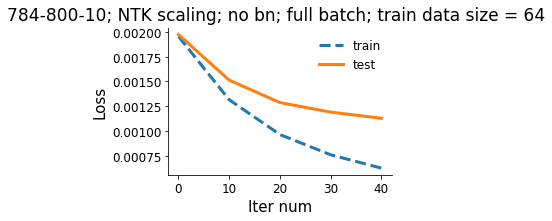

In [ ]:
title = '784-800-10; NTK scaling; no bn; full batch; train data size = 64'
fig = plot_loss(step_list, loss_ntk_scale_no_bn, title, fig_save_path)
del title

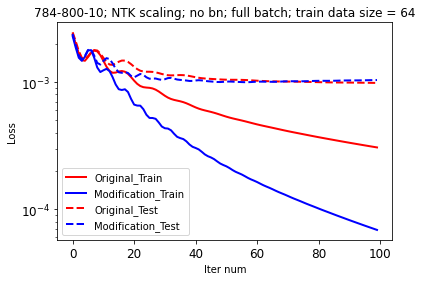

In [196]:
plt.plot(step_list,loss_ntk_scale_no_bn['train'],'r-',label='Original_Train',linewidth = 2)
plt.plot(step_list_,loss_no_scale_no_bn_['train'],'b-',label='Modification_Train',linewidth = 2)
plt.plot(step_list,loss_ntk_scale_no_bn['test'],'r--',label='Original_Test',linewidth = 2)
plt.plot(step_list_,loss_no_scale_no_bn_['test'],'b--',label='Modification_Test',linewidth = 2)
plt.title('784-800-10; NTK scaling; no bn; full batch; train data size = 64')
plt.xlabel('Iter num')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.savefig('/content/drive/My Drive/LCNN/newplots/attack3.pdf')

In [166]:
loss_no_scale_no_bn['train'][-1]

tensor(1.2898e-07)

In [167]:
loss_no_scale_no_bn_['train'][-1]

tensor(8.8039e-05)

# NTK scaling + batch norm

In [197]:
# 1.2 0.53. runstep=2
maxstep=1000
for scale in range(10):
    scale=(scale-2)*0.05+0.9
    for therd in range(10):
        therd=(therd-2)*0.05+0.7
        print('scale:{:03f},therd:{:03f}'.format(scale,therd))
        step_list_, loss_no_scale_no_bn_,train_loss = full_batch_train_(scale,therd,2,False,initialize = 'NTK', batchnorm = True, learning_rate = 0.1 * np.sqrt(784), ** shared_model_param_dict)
        if maxstep>train_loss:
            maxstep=train_loss
            sb=scale
            th=therd
print(maxstep,sb,th)

Streaming output truncated to the last 5000 lines.
Iter: 005/100 | Train Loss: 0.00164885
Adjusting Layer 1, Kernel Nodes: 776, Adptive Nodes:24
Iter: 006/100 | Train Loss: 0.00165815
Adjusting Layer 1, Kernel Nodes: 788, Adptive Nodes:12
Iter: 007/100 | Train Loss: 0.00144338
Iter: 008/100 | Train Loss: 0.00123808
Iter: 009/100 | Train Loss: 0.00115471
Iter: 010/100 | Train Loss: 0.00117768
Adjusting Layer 1, Kernel Nodes: 345, Adptive Nodes:455
Iter: 011/100 | Train Loss: 0.00114400
Iter: 012/100 | Train Loss: 0.00106154
Iter: 013/100 | Train Loss: 0.00094575
Iter: 014/100 | Train Loss: 0.00086654
Iter: 015/100 | Train Loss: 0.00084170
Iter: 016/100 | Train Loss: 0.00083000
Iter: 017/100 | Train Loss: 0.00079124
Iter: 018/100 | Train Loss: 0.00072934
Iter: 019/100 | Train Loss: 0.00067556
Iter: 020/100 | Train Loss: 0.00064686
Iter: 021/100 | Train Loss: 0.00063260
Iter: 022/100 | Train Loss: 0.00061369
Iter: 023/100 | Train Loss: 0.00058450
Iter: 024/100 | Train Loss: 0.00055364
Ite

In [200]:
step_list_, loss_no_scale_no_bn_,train_loss = full_batch_train_(1.05,0.6,2,True,initialize = 'NTK', batchnorm = True, learning_rate = 0.1 * np.sqrt(784), ** shared_model_param_dict)


Adjusting Layer 1, Kernel Nodes: 721, Adptive Nodes:79
Iter: 000/100 | Train Loss: 0.00243025
Iter: 001/100 | Train Loss: 0.00197599
Iter: 002/100 | Train Loss: 0.00155922
Iter: 003/100 | Train Loss: 0.00146102
Iter: 004/100 | Train Loss: 0.00162715
Adjusting Layer 1, Kernel Nodes: 628, Adptive Nodes:172
Iter: 005/100 | Train Loss: 0.00175585
Adjusting Layer 1, Kernel Nodes: 493, Adptive Nodes:307
Iter: 006/100 | Train Loss: 0.00153182
Iter: 007/100 | Train Loss: 0.00123259
Iter: 008/100 | Train Loss: 0.00114627
Iter: 009/100 | Train Loss: 0.00117522
Adjusting Layer 1, Kernel Nodes: 414, Adptive Nodes:386
Iter: 010/100 | Train Loss: 0.00113716
Iter: 011/100 | Train Loss: 0.00098196
Iter: 012/100 | Train Loss: 0.00085145
Iter: 013/100 | Train Loss: 0.00082034
Iter: 014/100 | Train Loss: 0.00082536
Adjusting Layer 1, Kernel Nodes: 642, Adptive Nodes:158
Iter: 015/100 | Train Loss: 0.00072763
Iter: 016/100 | Train Loss: 0.00064108
Iter: 017/100 | Train Loss: 0.00060837
Iter: 018/100 | Tra

In [199]:
step_list,  loss_ntk_scale_bn,train_loss =  full_batch_train(initialize = 'NTK', batchnorm = True, learning_rate =  0.1 * np.sqrt(784), ** shared_model_param_dict)

Iter: 000/100 | Train Loss: 0.00240460
Iter: 001/100 | Train Loss: 0.00197716
Iter: 002/100 | Train Loss: 0.00157913
Iter: 003/100 | Train Loss: 0.00143947
Iter: 004/100 | Train Loss: 0.00155030
Iter: 005/100 | Train Loss: 0.00172613
Iter: 006/100 | Train Loss: 0.00177632
Iter: 007/100 | Train Loss: 0.00164352
Iter: 008/100 | Train Loss: 0.00141492
Iter: 009/100 | Train Loss: 0.00122395
Iter: 010/100 | Train Loss: 0.00114596
Iter: 011/100 | Train Loss: 0.00116446
Iter: 012/100 | Train Loss: 0.00120952
Iter: 013/100 | Train Loss: 0.00121559
Iter: 014/100 | Train Loss: 0.00115919
Iter: 015/100 | Train Loss: 0.00106156
Iter: 016/100 | Train Loss: 0.00096427
Iter: 017/100 | Train Loss: 0.00089941
Iter: 018/100 | Train Loss: 0.00087482
Iter: 019/100 | Train Loss: 0.00087514
Iter: 020/100 | Train Loss: 0.00087645
Iter: 021/100 | Train Loss: 0.00086111
Iter: 022/100 | Train Loss: 0.00082608
Iter: 023/100 | Train Loss: 0.00078047
Iter: 024/100 | Train Loss: 0.00073774
Iter: 025/100 | Train Los

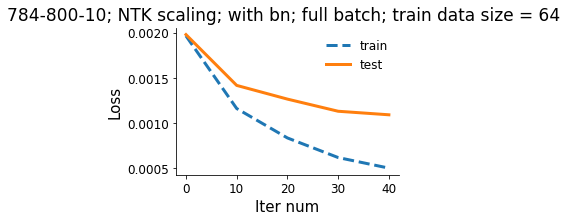

In [ ]:
title = '784-800-10; NTK scaling; with bn; full batch; train data size = 64'
fig = plot_loss(step_list, loss_ntk_scale_bn, title, fig_save_path)
del title

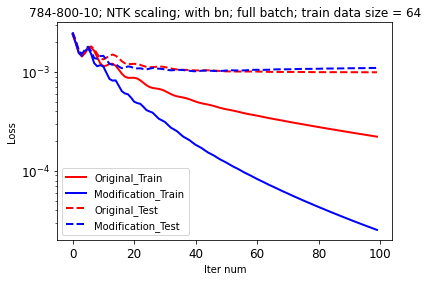

In [201]:
plt.plot(step_list,loss_ntk_scale_bn['train'],'r-',label='Original_Train',linewidth = 2)
plt.plot(step_list_,loss_no_scale_no_bn_['train'],'b-',label='Modification_Train',linewidth = 2)
plt.plot(step_list,loss_ntk_scale_bn['test'],'r--',label='Original_Test',linewidth = 2)
plt.plot(step_list_,loss_no_scale_no_bn_['test'],'b--',label='Modification_Test',linewidth = 2)
plt.title('784-800-10; NTK scaling; with bn; full batch; train data size = 64')
plt.xlabel('Iter num')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.savefig('/content/drive/My Drive/LCNN/newplots/attack4.pdf')

# Plot 

In [ ]:
loss_ntk_scale_bn

{'train': [tensor(0.0020),
  tensor(0.0012),
  tensor(0.0008),
  tensor(0.0006),
  tensor(0.0005)],
 'test': [tensor(0.0020),
  tensor(0.0014),
  tensor(0.0013),
  tensor(0.0011),
  tensor(0.0011)]}

In [ ]:
plot_dict = {'without scaling; without bn': loss_no_scale_no_bn,
            'without scaling; with bn': loss_no_scale_bn, 
            'NTK scaling; without bn': loss_ntk_scale_no_bn, 
            'NTK scaling; with bn': loss_ntk_scale_bn}



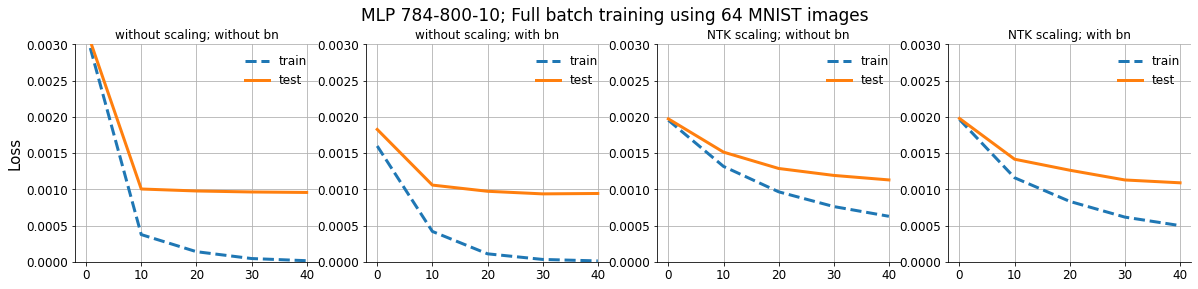

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

# key_idx = 0
key_idx = 0
for title in list(plot_dict.keys()):
#     title = list(plot_dict.keys())[key_idx]
    loss_dict = plot_dict[title]

    axs[key_idx].plot(step_list, loss_dict['train'], label = 'train', linewidth = 3 ,  linestyle =  '--')
    axs[key_idx].plot(step_list,loss_dict['test'], label = 'test', linewidth = 3)
    axs[key_idx].legend(frameon = False, fontsize = 12)
    
    if key_idx == 0:
        axs[key_idx].set_ylabel('Loss', fontsize = 15)
    axs[key_idx].set_title(title)

    axs[key_idx].set_ylim([0, 0.003])   
    axs[key_idx].grid(True)
    
    axs[key_idx] = simpleaxis(axs[key_idx])

    plt.suptitle('MLP 784-800-10; Full batch training using 64 MNIST images', fontsize = 17, y = 1.01)
    key_idx += 1
    
    
# plt.savefig(fig_save_path + 'fullbatch', format='png')


In [ ]:
# plot_dict = {'without scaling; without bn': (loss_no_scale_no_bn, aclist_no_scale_no_bn),
#             'without scaling; with bn': (loss_no_scale_bn, aclist_no_scale_bn),
#             'NTK scaling; without bn': (loss_ntk_scale_no_bn, aclist_ntk_scale_no_bn),
#             'NTK scaling; with bn': (loss_ntk_scale_bn, aclist_ntk_scale_bn)}



# fig, axs = plt.subplots(2, 4, figsize=(20, 6))

# # key_idx = 0
# key_idx = 0
# for title in list(plot_dict.keys()):
# #     title = list(plot_dict.keys())[key_idx]
#     loss_dict, acc_dict = plot_dict[title]

#     axs[0, key_idx].plot(step_list, loss_dict['train'], label = 'train', linewidth = 3 ,  linestyle =  '--')
#     axs[0, key_idx].plot(step_list,loss_dict['test'], label = 'test', linewidth = 3)
#     axs[0, key_idx].legend(frameon = False, fontsize = 12)
    
#     if key_idx == 0:
#         axs[0, key_idx].set_ylabel('Loss', fontsize = 15)
#     axs[0, key_idx].set_title(title)

#     axs[1, key_idx].plot(step_list, acc_dict['train'], label = 'train', linewidth = 3, linestyle =  '--')
#     axs[1, key_idx].plot(step_list, acc_dict['test'], label = 'test', linewidth = 3)
#     axs[1, key_idx].legend(frameon = False, fontsize = 12)
#     axs[1, key_idx].set_xlabel('Iter num', fontsize = 15)
    
#     if key_idx == 0:
#         axs[1, key_idx].set_ylabel('Acc', fontsize = 15)

#     axs[0, key_idx].set_ylim([0, 0.003])   
#     axs[1, key_idx].set_ylim([40, 101])    
#     axs[0, key_idx].grid(True)
#     axs[1, key_idx].grid(True)
    
#     axs[0, key_idx] = simpleaxis(axs[0, key_idx])
#     axs[1, key_idx] = simpleaxis(axs[1, key_idx])

#     plt.suptitle('MLP 784-800-10; Full batch training using 64 MNIST images', fontsize = 17)
#     key_idx += 1
    
    
# plt.savefig(fig_save_path + 'fullbatch', format='png')
